In [1]:
!pip install kaggle

In [2]:
 # Upload kaggle.json file

 from google.colab import files
 uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
 !mkdir -p ~/.kaggle
 !cp kaggle.json ~/.kaggle/
 !chmod 600 ~/.kaggle/kaggle.json


In [4]:
# Run this if RESIDE Dataset is used
!kaggle datasets download -d samplesem8/renamedresidedatasetforsdpproject --unzip

Dataset URL: https://www.kaggle.com/datasets/samplesem8/renamedresidedatasetforsdpproject
License(s): other


In [5]:
import os
import time
import glob
import pickle
import random
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.losses import MeanSquaredError

In [6]:
IM_SIZE = (720, 1280)
LOAD_MODEL = False

In [7]:
def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, size=IM_SIZE, antialias = True)
    img = img / 255.0
    return img

In [8]:
def display_img(model, hazy_img, orig_img):
    pred = model(hazy_img, training = True)
    plt.figure(figsize = (15,15))

    display_list = [hazy_img[0], orig_img[0], pred[0]]
    title = ['Input Image', 'Real Image', 'Output Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')

    plt.show()

In [9]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [10]:
# Run this if RESIDE Dataset is used


import glob
import random
import os

def data_path(orig_img_path, hazy_img_path):
    train_img = []
    val_img = []
    test_img = []

    # Get all clear image paths
    clear_imgs = glob.glob(os.path.join(orig_img_path, '*.png'))  # ITS clear images are .png

    # Create a mapping: clear image name (without extension) → all hazy images
    hazy_imgs = glob.glob(os.path.join(hazy_img_path, '*.png'))
    hazy_img_dict = {}

    for hazy_path in hazy_imgs:
        hazy_name = os.path.basename(hazy_path)
        # Extract the clear image ID from hazy image name, e.g., "1_1.png" → "1"
        base_name = hazy_name.split('_')[0]
        hazy_img_dict.setdefault(base_name, []).append(hazy_path)

    # Shuffle the clear images and split
    random.shuffle(clear_imgs)
    n = len(clear_imgs)

    train_keys = clear_imgs[: int(0.8 * n)]
    val_keys = clear_imgs[int(0.8 * n): int(0.9 * n)]
    test_keys = clear_imgs[int(0.9 * n):]

    # Create dictionaries to determine the split
    split_dict = {img: 'train' for img in train_keys}
    split_dict.update({img: 'val' for img in val_keys})
    split_dict.update({img: 'test' for img in test_keys})

    for clear_path in clear_imgs:
        clear_name = os.path.basename(clear_path)
        base_name = os.path.splitext(clear_name)[0]

        if base_name not in hazy_img_dict:
            print(f"Warning: No hazy images found for {clear_name}")
            continue

        for hazy_path in hazy_img_dict[base_name]:
            pair = [hazy_path, clear_path]
            split = split_dict[clear_path]
            if split == 'train':
                train_img.append(pair)
            elif split == 'val':
                val_img.append(pair)
            else:
                test_img.append(pair)

    return train_img, val_img, test_img

# Call the function with your dataset paths
train_images, val_images, test_images = data_path(
    orig_img_path='/content/Reside/Indoor Training Set (ITS)/clear',
    hazy_img_path='/content/Reside/Indoor Training Set (ITS)/hazy'
)

# Print counts
print(f"Total image pairs: {len(train_images + val_images + test_images)}")
print(f"Training pairs: {len(train_images)}")
print(f"Validation pairs: {len(val_images)}")
print(f"Test pairs: {len(test_images)}")

Total image pairs: 13990
Training pairs: 11190
Validation pairs: 1400
Test pairs: 1400


In [11]:
'''
def dataloader(train_data, val_data, test_data, batch_size):
    train_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in train_data]).map(lambda x: load_image(x))
    train_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in train_data]).map(lambda x: load_image(x))
    train = tf.data.Dataset.zip((train_data_haze, train_data_orig)).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    val_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in val_data]).map(lambda x: load_image(x))
    val_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in val_data]).map(lambda x: load_image(x))
    val = tf.data.Dataset.zip((val_data_haze, val_data_orig)).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    test_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in test_data]).map(lambda x: load_image(x))
    test_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in test_data]).map(lambda x: load_image(x))
    test = tf.data.Dataset.zip((test_data_haze, test_data_orig)).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train, val, test
'''

import tensorflow as tf

def dataloader(train_data, val_data, test_data, batch_size=1):
    def load_image_pair(hazy_path, clear_path):
        # hazy_path & clear_path are tf.string tensors here

        # Read + decode → uint8 tensor
        hazy = tf.io.read_file(hazy_path)
        hazy = tf.image.decode_png(hazy, channels=3)
        # Cast to float32 and normalize in one step:
        hazy = tf.cast(hazy, tf.float32) / 255.0

        clear = tf.io.read_file(clear_path)
        clear = tf.image.decode_png(clear, channels=3)
        clear = tf.cast(clear, tf.float32) / 255.0

        return hazy, clear

    def create_dataset(pairs):
        if not pairs:
            # empty fallback
            return tf.data.Dataset.from_tensor_slices(([], []))

        # unzip into two Python lists of strings
        hazy_paths, clear_paths = zip(*pairs)
        ds = tf.data.Dataset.from_tensor_slices(
            (list(hazy_paths), list(clear_paths))
        )
        ds = ds.map(load_image_pair, num_parallel_calls=tf.data.AUTOTUNE)
        return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return (
        create_dataset(train_data),
        create_dataset(val_data),
        create_dataset(test_data),
    )



In [12]:
import random

# Get already split data from data_path()
train_data, val_data, test_data = data_path(
    orig_img_path='/content/Reside/Indoor Training Set (ITS)/clear',
    hazy_img_path ='/content/Reside/Indoor Training Set (ITS)/hazy'
)


# Optional: Shuffle for randomness (especially helpful if ordering might be biased)
random.shuffle(train_data)
random.shuffle(val_data)
random.shuffle(test_data)

# Print actual sizes
print(f"Training pairs:   {len(train_data)}")
print(f"Validation pairs: {len(val_data)}")
print(f"Test pairs:       {len(test_data)}")

# Load datasets using dataloader
train, val, test = dataloader(train_data, val_data, test_data, batch_size=1)

Training pairs:   11190
Validation pairs: 1400
Test pairs:       1400


In [13]:
def preprocess(img):
    return tf.image.convert_image_dtype(img, tf.float32)

# Apply if needed (only once before training/testing)
train = train.map(lambda x, y: (preprocess(x), preprocess(y)))
val = val.map(lambda x, y: (preprocess(x), preprocess(y)))
test = test.map(lambda x, y: (preprocess(x), preprocess(y)))

In [25]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, Concatenate,
    Multiply, Subtract, Add,
    Activation, BatchNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
import pickle
import logging
import os
import time  # Import time module to track execution time
from datetime import datetime  # To get current date and time
import pytz

# Setup logging
logging.basicConfig(level=logging.INFO)

def dehaze_net():
    inputs = Input(shape=(None, None, 3))  # Dynamic input

    # === Feature Extraction Blocks ===
    conv1 = Conv2D(16, 1, padding='same', activation='relu')(inputs)
    conv2 = Conv2D(16, 3, padding='same', activation='relu')(conv1)
    concat1 = Concatenate()([conv1, conv2])

    conv3 = Conv2D(16, 5, padding='same', activation='relu')(concat1)
    concat2 = Concatenate()([conv2, conv3])

    conv4 = Conv2D(16, 7, padding='same', activation='relu')(concat2)
    concat3 = Concatenate()([conv1, conv2, conv3, conv4])

    conv5 = Conv2D(16, 3, padding='same', activation='relu')(concat3)
    K = Conv2D(3, 1, padding='same')(conv5)  # K-map

    # === AOD-Net Dehaze Formula ===
    k_mul_x   = Multiply()([K, inputs])           # K * x
    k_mul_x_m = Subtract()([k_mul_x, K])          # K*x - K

    # Reshape to ensure broadcast compatibility for adding constant
    constant_1 = tf.constant(1., dtype=tf.float32)
    constant_1_reshaped = tf.reshape(constant_1, [1, 1, 1, 1])  # Ensure it matches the input shape

    plus_one  = Add()([k_mul_x_m, constant_1_reshaped])  # +1

    # === Refinement Block ===
    x = Conv2D(32, 3, padding='same', activation='relu')(plus_one)
    x = BatchNormalization()(x)
    x = Conv2D(3, 3, padding='same')(x)

    # === Final Activation to clip into [0,1] ===
    output = Activation('sigmoid')(x)

    model = Model(inputs=inputs, outputs=output)
    model.summary()
    return model

# === Configurable Parameters & Training Settings ===
EPOCHS_TO_TRAIN = 1  # Update daily as needed
MODEL_PATH = '/content/aod_net_refined.keras'
HISTORY_PATH = '/content/training_history.pkl'

#early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# === Data Summary ===
print(f"Train batches:                 {len(train)}")
print(f"Validation batches:            {len(val)}")
print(f"Number of Epochs this session: {EPOCHS_TO_TRAIN}")

# === Track Execution Time ===
start_time = time.time()  # Record the start time

# === Load or Initialize Model ===
if os.path.exists(MODEL_PATH):
    model = tf.keras.models.load_model(MODEL_PATH)
    model.compile(optimizer=Adam(learning_rate=1e-3), loss=MeanSquaredError())
    with open(HISTORY_PATH, 'rb') as f:
        history = pickle.load(f)
    print("Loaded existing model and history.")
else:
    model = dehaze_net()
    model.compile(optimizer=Adam(learning_rate=1e-3), loss=MeanSquaredError())
    history = {'loss': [], 'val_loss': []}  # Initialize empty history
    print("New model created.")

# === Always Train for More Epochs ===
try:
    # Use the first code if Early Stopping is used else use the second code!
    #history_obj = model.fit(
        #train,
        #validation_data=val,
        #epochs=EPOCHS_TO_TRAIN,
        #verbose=1,
        #callbacks=[early_stop]
    #)
    history_obj = model.fit(
        train,
        validation_data=val,
        epochs=EPOCHS_TO_TRAIN,
        verbose=1
    )
except Exception as e:
    print(f"Training stopped due to error: {e}")
else:
    # Update and extend history
    new_history = history_obj.history
    for key in new_history:
        if key not in history:
            history[key] = []
        history[key].extend(new_history[key])

    # Save updated history and model
    with open(HISTORY_PATH, 'wb') as f:
        pickle.dump(history, f)
    model.save(MODEL_PATH)
    print("\nModel and training history saved successfully.")

# === Track Total Execution Time ===
end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time

# Convert elapsed time to hours, minutes, seconds
hours = elapsed_time // 3600
minutes = (elapsed_time % 3600) // 60
seconds = elapsed_time % 60

print(f"\nTotal epochs trained so far: {len(history['loss'])}")
print(f"Training completed in {int(hours)} hours, {int(minutes)} minutes, {int(seconds)} seconds.")

# === Logging Training Session Details ===
log_path = "/content/training_log.txt"  # Log file path

# Calculate average training and validation loss for this session
avg_train_loss = sum(history_obj.history['loss']) / len(history_obj.history['loss'])
avg_val_loss = sum(history_obj.history['val_loss']) / len(history_obj.history['val_loss'])

# Format log entry

# Get current time in IST
india_timezone = pytz.timezone("Asia/Kolkata")
timestamp = datetime.now(india_timezone).strftime("%Y-%m-%d %I:%M:%S %p (%Z)")

log_entry = (
    f"Date & Time:                 {timestamp}\n"
    f"Epochs Trained This Session: {EPOCHS_TO_TRAIN}\n"
    f"Total Epochs Trained So Far: {len(history['loss'])}\n"
    f"Time Taken:                  {int(hours)}h {int(minutes)}m {int(seconds)}s\n"
    f"Average Training Loss:       {avg_train_loss:.4f}\n"
    f"Average Validation Loss:     {avg_val_loss:.4f}\n"
    f"{'-'*40}\n"
)

# Read existing log file and prepend the new entry at the top
if os.path.exists(log_path):
    with open(log_path, "r") as log_file:
        existing_log = log_file.read()
    with open(log_path, "w") as log_file:
        log_file.write(log_entry + existing_log)  # Prepend the new log entry
else:
    # If log file does not exist, create it and write the log entry
    with open(log_path, "w") as log_file:
        log_file.write(log_entry)

print(f"\nTraining log updated at {log_path}")


Train batches:                 11190
Validation batches:            1400
Number of Epochs this session: 1
Loaded existing model and history.
11190/11190 ━━━━━━━━━━━━━━━━━━━━ 709s 63ms/step - loss: 0.0127 - val_loss: 0.0345

Model and training history saved successfully.

Total epochs trained so far: 12
Training completed in 0 hours, 12 minutes, 24 seconds.

Training log updated at /content/training_log.txt


In [26]:
history

{'loss': [0.02013859525322914,
  0.018131334334611893,
  0.0165718924254179,
  0.015898868441581726,
  0.014848722144961357,
  0.014026736840605736,
  0.013571253046393394,
  0.013227754272520542,
  0.01295155007392168,
  0.0128655219450593,
  0.012727365829050541,
  0.0125897116959095],
 'val_loss': [0.043769609183073044,
  0.0343683622777462,
  0.04182679206132889,
  0.03522991016507149,
  0.01849515177309513,
  0.01839146576821804,
  0.023826198652386665,
  0.017563359811902046,
  0.01829330250620842,
  0.017953408882021904,
  0.0232396200299263,
  0.034512393176555634]}


Example 1:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
Saved output image to: Results/dehazed1.png
Saved real clear image to: Results/real1.png


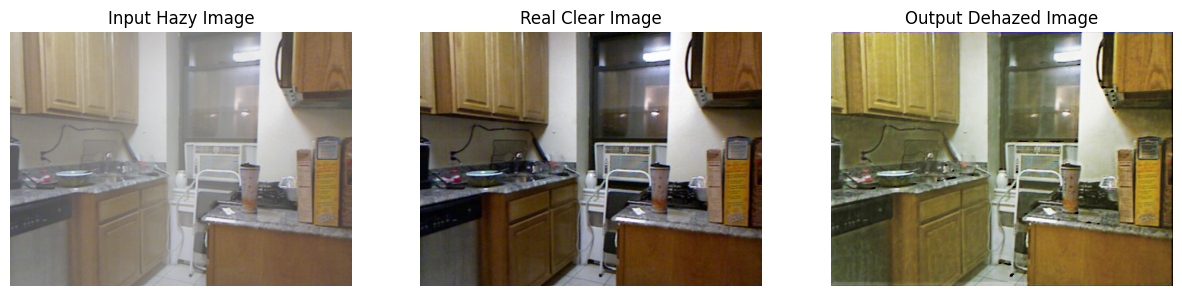


Example 2:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Saved output image to: Results/dehazed2.png
Saved real clear image to: Results/real2.png


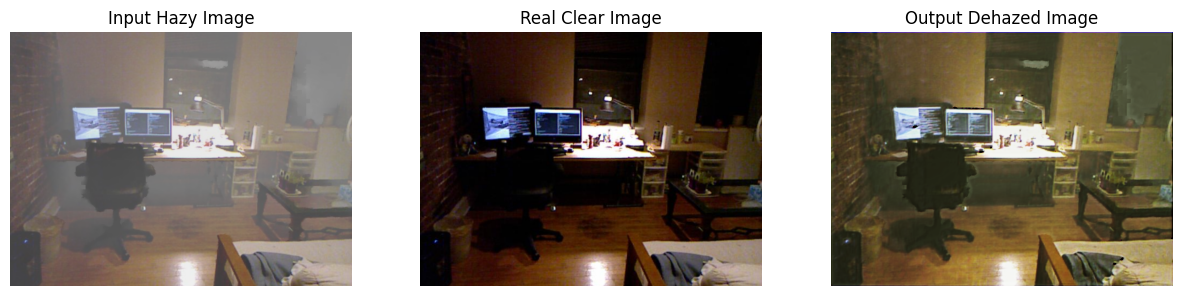


Example 3:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Saved output image to: Results/dehazed3.png
Saved real clear image to: Results/real3.png


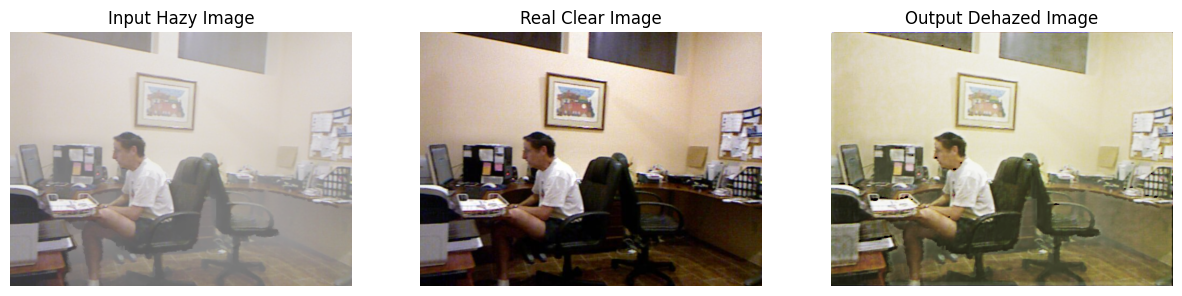

In [27]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image  # Add PIL for saving

def display_img(model, hazy, clear, index, results_dir="Results"):
    # Ensure input image has shape (H, W, 3)
    if len(hazy.shape) == 4:
        hazy = tf.squeeze(hazy, axis=0)
    if len(clear.shape) == 4:
        clear = tf.squeeze(clear, axis=0)

    # Predict and squeeze batch dimension
    pred = model.predict(tf.expand_dims(hazy, 0))[0]

    # Clip values for display (ensure they're between 0 and 1)
    hazy = np.clip(hazy, 0, 1)
    clear = np.clip(clear, 0, 1)
    pred = np.clip(pred, 0, 1)

    # Create results directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)

    # === Save output dehazed image ===
    dehazed_filename = os.path.join(results_dir, f"dehazed{index}.png")
    pred_uint8 = (pred * 255).astype(np.uint8)
    im_pred = Image.fromarray(pred_uint8)
    im_pred.save(dehazed_filename)
    print(f"Saved output image to: {dehazed_filename}")

    # === Save real clear image ===
    real_filename = os.path.join(results_dir, f"real{index}.png")
    clear_uint8 = (clear * 255).astype(np.uint8)
    im_clear = Image.fromarray(clear_uint8)
    im_clear.save(real_filename)
    print(f"Saved real clear image to: {real_filename}")

    # === Plot images ===
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(hazy)
    axs[0].set_title('Input Hazy Image')
    axs[0].axis('off')

    axs[1].imshow(clear)
    axs[1].set_title('Real Clear Image')
    axs[1].axis('off')

    axs[2].imshow(pred)
    axs[2].set_title('Output Dehazed Image')
    axs[2].axis('off')

    plt.show()

# === Example Usage ===
for i, (hz, og) in enumerate(test):
    if i == 3:  # Limiting to 3 examples
        break
    print(f"\nExample {i+1}:")
    display_img(model, hz, og, index=i+1)


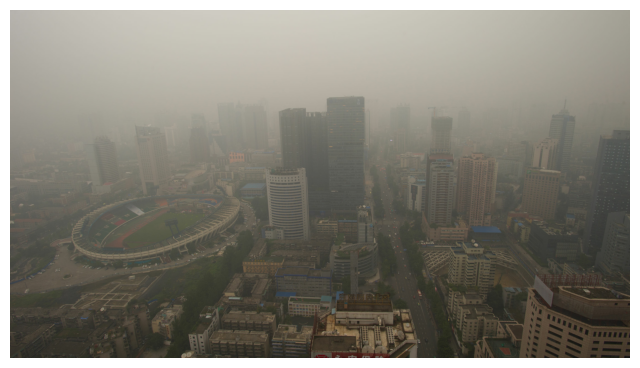

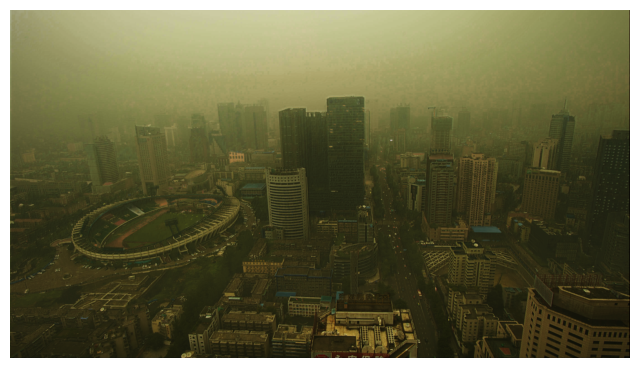

In [28]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# === Helper functions ===
def load_image(image_path):
    """Loads and preprocesses image from the given path."""
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)  # Normalize to [0,1]
    return img

def tensor_to_image(tensor, size=(8, 6)):
    """Converts tensor to displayable image with adjustable size."""
    tensor = tf.clip_by_value(tensor, 0, 1)
    array = tensor.numpy()
    if array.ndim == 4:
        array = array[0]  # Remove batch dimension
    plt.figure(figsize=size)
    plt.imshow(array)
    plt.axis('off')
    plt.show()

# === Load Test Image ===
test_input_image = '/content/haze1.jpg'  # Change to your image path if needed
in_img = load_image(test_input_image)
tensor_to_image(in_img)  # Show input image

# === Predict ===
img = tf.expand_dims(in_img, 0)  # Add batch dimension
pred = model(img)
tensor_to_image(pred)  # Show predicted (dehazed) image

MSE Vs Epoch Graph



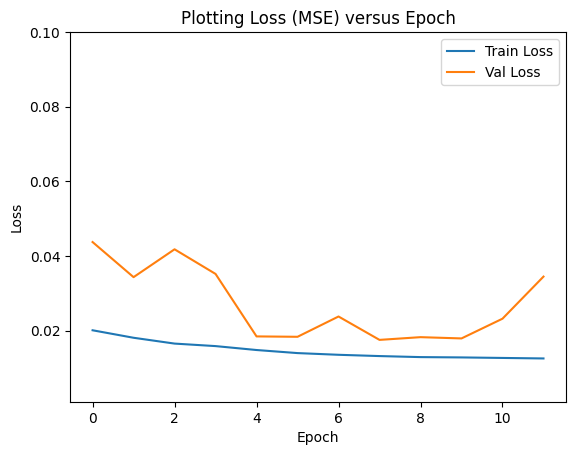

Plot saved as /content/mse_vs_epoch_graph.png


In [29]:
import matplotlib.pyplot as plt

# MSE Vs Epoch Graph
print("MSE Vs Epoch Graph\n")

plt.title("Plotting Loss (MSE) versus Epoch")
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.001, 0.1])
plt.legend()

# Save the plot before displaying
plot_path = "/content/mse_vs_epoch_graph.png"
plt.savefig(plot_path)
plt.show()

print(f"Plot saved as {plot_path}")

In [30]:
train_loss = history['loss'][-1]
val_loss = history['val_loss'][-1]

print(f"Training loss at the last epoch of training: {train_loss}")
print(f"Validation loss at the last epoch of training: {val_loss}")

Training loss at the last epoch of training: 0.0125897116959095
Validation loss at the last epoch of training: 0.034512393176555634


In [31]:
# Calculate PSNR Value

import math
max_pixel_value = 255
val_MSE = history['val_loss'][-1]
PSNR = 10 * math.log10((max_pixel_value ** 2) / val_MSE)
print(f"PSNR Value: {PSNR}")

PSNR Value: 62.7510528545541


In [32]:
import cv2
import os
from skimage.metrics import structural_similarity as ssim

# Paths to the images
image1_path = "/content/Results/real1.png"     # Reference clear image
image2_path = "/content/Results/dehazed1.png"  # Generated dehazed image

# Check if both files exist
if not os.path.exists(image1_path):
    raise FileNotFoundError(f"File not found: {image1_path}")
if not os.path.exists(image2_path):
    raise FileNotFoundError(f"File not found: {image2_path}")

# Load the images using OpenCV
image1 = cv2.imread(image1_path)
image2 = cv2.imread(image2_path)

# Check if images were loaded successfully
if image1 is None:
    raise ValueError(f"Failed to load image: {image1_path}")
if image2 is None:
    raise ValueError(f"Failed to load image: {image2_path}")

# Resize image1 to match image2's size, if necessary
if image1.shape != image2.shape:
    image1 = cv2.resize(image1, (image2.shape[1], image2.shape[0]))

# Convert images from BGR (OpenCV default) to RGB
image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# Compute SSIM (for color images)
ssim_value, _ = ssim(image1_rgb, image2_rgb, full=True, channel_axis=-1)

# Print the SSIM value
print(f"SSIM: {ssim_value:.4f}")


SSIM: 0.8209


In [33]:
import zipfile
import os
from datetime import datetime
import pytz
import time
from google.colab import files

# Files to include
files_to_zip = [
    '/content/aod_net_refined.keras',
    '/content/training_history.pkl',
    '/content/mse_vs_epoch_graph.png',
    '/content/training_log.txt'
]

# Convert current time to IST
india_timezone = pytz.timezone('Asia/Kolkata')
current_time = datetime.now(india_timezone)
formatted_time = current_time.strftime("%Y-%m-%d , %I-%M %p")

# Convert IST datetime to timestamp (epoch seconds)
ist_timestamp = time.mktime(current_time.timetuple())

# Update the modified time of each file to IST
for file_path in files_to_zip:
    os.utime(file_path, (ist_timestamp, ist_timestamp))

# Name of the zip file
zip_filename = f"Last Model and Training History Files ({formatted_time}).zip"

# Create and write zip file
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for file_path in files_to_zip:
        zipf.write(file_path, os.path.basename(file_path))

print(f"Files have been zipped into {zip_filename}")

# Download in Colab
files.download(zip_filename)
print("Zip file downloaded")

Files have been zipped into Last Model and Training History Files (2025-05-04 , 11-35 PM).zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Zip file downloaded
